Connected to py39 (Python 3.9.19)

In [4]:
import torch
import numpy as np

In [5]:
import sys
import os

# Add the current file's directory to the Python path
current_dir = os.path.dirname(os.path.abspath('..'))
if current_dir not in sys.path:
    sys.path.append(current_dir)

from solution import *

In [12]:
e = torch.tensor(-16)
m = torch.tensor(1.0)

t = 2.0**e*m
t.round()

tensor(1.5259e-05)

0.0625

In [3]:
# Generate the full range of subnormals for bfloat16

# Create an empty tensor to store the subnormal values
subnormals = torch.empty(128, dtype=torch.int32)

# Set the exponent to 0 for all subnormals
exponent = 0

# Iterate through all possible mantissa values for subnormals
for i in range(128):
    # Create the mantissa as a binary number
    mantissa = i
    
    # Combine exponent and mantissa
    # The sign bit is 0 (positive) for all values here
    bits = (exponent << 7) | mantissa
    
    # Store the bits in the tensor
    subnormals[i] = bits

# Convert the int32 representation to bfloat16
subnormal_bfloat16 = bits_to_bfloat16(subnormals)

print("Subnormal bfloat16 values:")
print(subnormal_bfloat16)

# You can also generate negative subnormals by setting the sign bit
negative_subnormals = subnormals | (1 << 15)
negative_subnormal_bfloat16 = bits_to_bfloat16(negative_subnormals)

print("\nNegative subnormal bfloat16 values:")
print(negative_subnormal_bfloat16)



Subnormal bfloat16 values:
tensor([0.0000e+00, 9.1835e-41, 1.8367e-40, 2.7551e-40, 3.6734e-40, 4.5918e-40,
        5.5101e-40, 6.4285e-40, 7.3468e-40, 8.2652e-40, 9.1835e-40, 1.0102e-39,
        1.1020e-39, 1.1939e-39, 1.2857e-39, 1.3775e-39, 1.4694e-39, 1.5612e-39,
        1.6530e-39, 1.7449e-39, 1.8367e-39, 1.9285e-39, 2.0204e-39, 2.1122e-39,
        2.2041e-39, 2.2959e-39, 2.3877e-39, 2.4796e-39, 2.5714e-39, 2.6632e-39,
        2.7551e-39, 2.8469e-39, 2.9387e-39, 3.0306e-39, 3.1224e-39, 3.2142e-39,
        3.3061e-39, 3.3979e-39, 3.4897e-39, 3.5816e-39, 3.6734e-39, 3.7653e-39,
        3.8571e-39, 3.9489e-39, 4.0408e-39, 4.1326e-39, 4.2244e-39, 4.3163e-39,
        4.4081e-39, 4.4999e-39, 4.5918e-39, 4.6836e-39, 4.7754e-39, 4.8673e-39,
        4.9591e-39, 5.0510e-39, 5.1428e-39, 5.2346e-39, 5.3265e-39, 5.4183e-39,
        5.5101e-39, 5.6020e-39, 5.6938e-39, 5.7856e-39, 5.8775e-39, 5.9693e-39,
        6.0611e-39, 6.1530e-39, 6.2448e-39, 6.3366e-39, 6.4285e-39, 6.5203e-39,
        6.612

In [4]:
# Construct the full range of uint8 for e4m3
x_e4m3 = torch.arange(0, 2**8, dtype=torch.int32)
s_e4m3, e_e4m3, m_e4m3 = decompose_8bit_e4m3(x_e4m3)

# Generate fp8 e4m3 as floating points
fp8_e4m3 = torch.zeros(256, dtype=torch.float32)

for i in range(256):
    sign = (i & 0b10000000) >> 7
    exponent = (i & 0b01111000) >> 3
    mantissa = i & 0b00000111

    # Handle special cases
    if exponent == 0:
        if mantissa == 0:
            # Zero
            fp8_e4m3[i] = 0.0 if sign == 0 else -0.0
        else:
            # Subnormal numbers
            fp8_e4m3[i] = ((-1)**sign) * (2**-6) * (mantissa / 8)
    elif exponent == 15:
        if mantissa == 0:
            # Infinity
            fp8_e4m3[i] = float('inf') if sign == 0 else float('-inf')
        else:
            # NaN
            fp8_e4m3[i] = float('nan')
    else:
        # Normal numbers
        fp8_e4m3[i] = ((-1)**sign) * (2**(exponent - 7)) * (1 + mantissa / 8)

print("FP8 E4M3 range:")
print(fp8_e4m3)


FP8 E4M3 range:
tensor([ 0.0000e+00,  1.9531e-03,  3.9062e-03,  5.8594e-03,  7.8125e-03,
         9.7656e-03,  1.1719e-02,  1.3672e-02,  1.5625e-02,  1.7578e-02,
         1.9531e-02,  2.1484e-02,  2.3438e-02,  2.5391e-02,  2.7344e-02,
         2.9297e-02,  3.1250e-02,  3.5156e-02,  3.9062e-02,  4.2969e-02,
         4.6875e-02,  5.0781e-02,  5.4688e-02,  5.8594e-02,  6.2500e-02,
         7.0312e-02,  7.8125e-02,  8.5938e-02,  9.3750e-02,  1.0156e-01,
         1.0938e-01,  1.1719e-01,  1.2500e-01,  1.4062e-01,  1.5625e-01,
         1.7188e-01,  1.8750e-01,  2.0312e-01,  2.1875e-01,  2.3438e-01,
         2.5000e-01,  2.8125e-01,  3.1250e-01,  3.4375e-01,  3.7500e-01,
         4.0625e-01,  4.3750e-01,  4.6875e-01,  5.0000e-01,  5.6250e-01,
         6.2500e-01,  6.8750e-01,  7.5000e-01,  8.1250e-01,  8.7500e-01,
         9.3750e-01,  1.0000e+00,  1.1250e+00,  1.2500e+00,  1.3750e+00,
         1.5000e+00,  1.6250e+00,  1.7500e+00,  1.8750e+00,  2.0000e+00,
         2.2500e+00,  2.5000e+00,  

In [5]:
# Construct the full range of uint8
x = torch.arange(0, 2**8, dtype=torch.int32)
s, e, m = decompose_8bit_e5m2(x)
# Generate fp8 e5m2 as floating points
fp8_e5m2 = torch.zeros(256, dtype=torch.float32)

for i in range(256):
    sign = (i & 0b10000000) >> 7
    exponent = (i & 0b01111100) >> 2
    mantissa = i & 0b00000011

    # Handle special cases
    if exponent == 0:
        if mantissa == 0:
            # Zero
            fp8_e5m2[i] = 0.0 if sign == 0 else -0.0
        else:
            # Subnormal numbers
            fp8_e5m2[i] = ((-1)**sign) * (2**-14) * (mantissa / 4)
    elif exponent == 31:
        if mantissa == 0:
            # Infinity
            fp8_e5m2[i] = float('inf') if sign == 0 else float('-inf')
        else:
            # NaN
            fp8_e5m2[i] = float('nan')
    else:
        # Normal numbers
        fp8_e5m2[i] = ((-1)**sign) * (2**(exponent - 15)) * (1 + mantissa / 4)

print("FP8 E5M2 range:")
print(fp8_e5m2)


FP8 E5M2 range:
tensor([ 0.0000e+00,  1.5259e-05,  3.0518e-05,  4.5776e-05,  6.1035e-05,
         7.6294e-05,  9.1553e-05,  1.0681e-04,  1.2207e-04,  1.5259e-04,
         1.8311e-04,  2.1362e-04,  2.4414e-04,  3.0518e-04,  3.6621e-04,
         4.2725e-04,  4.8828e-04,  6.1035e-04,  7.3242e-04,  8.5449e-04,
         9.7656e-04,  1.2207e-03,  1.4648e-03,  1.7090e-03,  1.9531e-03,
         2.4414e-03,  2.9297e-03,  3.4180e-03,  3.9062e-03,  4.8828e-03,
         5.8594e-03,  6.8359e-03,  7.8125e-03,  9.7656e-03,  1.1719e-02,
         1.3672e-02,  1.5625e-02,  1.9531e-02,  2.3438e-02,  2.7344e-02,
         3.1250e-02,  3.9062e-02,  4.6875e-02,  5.4688e-02,  6.2500e-02,
         7.8125e-02,  9.3750e-02,  1.0938e-01,  1.2500e-01,  1.5625e-01,
         1.8750e-01,  2.1875e-01,  2.5000e-01,  3.1250e-01,  3.7500e-01,
         4.3750e-01,  5.0000e-01,  6.2500e-01,  7.5000e-01,  8.7500e-01,
         1.0000e+00,  1.2500e+00,  1.5000e+00,  1.7500e+00,  2.0000e+00,
         2.5000e+00,  3.0000e+00,  

Computing errors: 100%|██████████| 19/19 [00:51<00:00,  2.73s/it] 


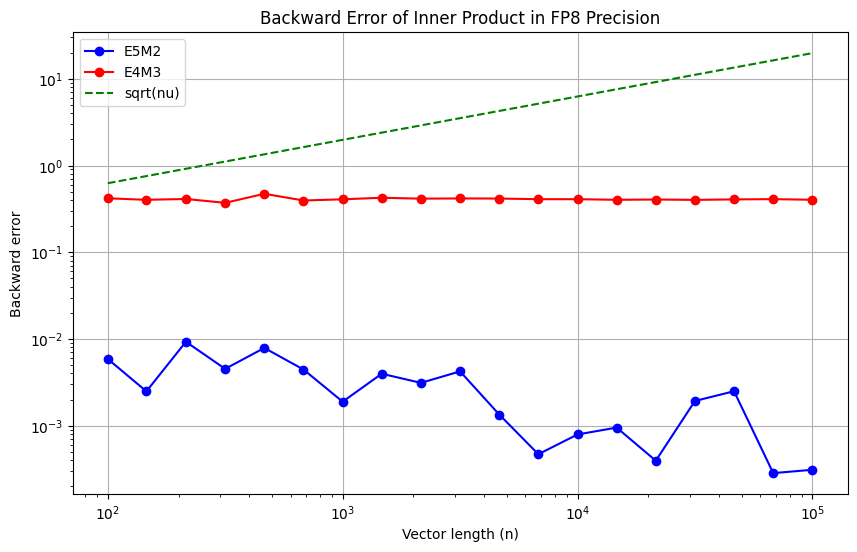

E5M2 results:
Minimum error: 2.84e-04
Maximum error: 9.28e-03
Mean error: 2.98e-03

E4M3 results:
Minimum error: 3.71e-01
Maximum error: 4.72e-01
Mean error: 4.10e-01


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

def compute_inner_product_fp8(x, y, n_mantissa):
    x_tensor = torch.tensor(x, dtype=torch.bfloat16)
    y_tensor = torch.tensor(y, dtype=torch.bfloat16)
    
    x_fp8 = round_to_fp8_represented_as_int8(x_tensor, n_mantissa, None)
    y_fp8 = round_to_fp8_represented_as_int8(y_tensor, n_mantissa, None)
    
    x_fp8_float = undo_int8_fp8(x_fp8, n_mantissa)
    y_fp8_float = undo_int8_fp8(y_fp8, n_mantissa)
    
    return torch.dot(x_fp8_float.flatten(), y_fp8_float.flatten()).item()

def backward_error(true_result, computed_result):
    return np.abs(true_result - computed_result) / np.abs(true_result)

# Generate n values
n_values = np.logspace(2, 5, num=19, dtype=int)

# Initialize lists to store results
backward_errors_e5m2 = []
backward_errors_e4m3 = []

# Compute inner products and backward errors
for n in tqdm(n_values, desc="Computing errors"):
    # Generate x and y vectors at bfloat16 precision
    x = torch.rand(n, dtype=torch.bfloat16).to(torch.float32).numpy()
    y = torch.rand(n, dtype=torch.bfloat16).to(torch.float32).numpy()

    
    # Compute true result in double precision
    true_result = np.dot(x, y)
    
    # Compute result in e5m2 precision
    e5m2_result = compute_inner_product_fp8(x, y, 2)
    
    # Compute result in e4m3 precision
    e4m3_result = compute_inner_product_fp8(x, y, 3)
    
    # Compute backward errors
    error_e5m2 = backward_error(true_result, e5m2_result)
    error_e4m3 = backward_error(true_result, e4m3_result)
    
    backward_errors_e5m2.append(error_e5m2)
    backward_errors_e4m3.append(error_e4m3)

# Create the plot
plt.figure(figsize=(10, 6))
plt.loglog(n_values, backward_errors_e5m2, 'bo-', label='E5M2')
plt.loglog(n_values, backward_errors_e4m3, 'ro-', label='E4M3')

# Add sqrt(nu) line
eps = 0.0625  # e5m2 epsilon (2^-4)
sqrt_nu = np.sqrt(n_values) * eps
plt.loglog(n_values, sqrt_nu, 'g--', label='sqrt(nu)')

plt.xlabel('Vector length (n)')
plt.ylabel('Backward error')
plt.title('Backward Error of Inner Product in FP8 Precision')
plt.legend()
plt.grid(True)
plt.show()

print("E5M2 results:")
print(f"Minimum error: {min(backward_errors_e5m2):.2e}")
print(f"Maximum error: {max(backward_errors_e5m2):.2e}")
print(f"Mean error: {np.mean(backward_errors_e5m2):.2e}")

print("\nE4M3 results:")
print(f"Minimum error: {min(backward_errors_e4m3):.2e}")
print(f"Maximum error: {max(backward_errors_e4m3):.2e}")
print(f"Mean error: {np.mean(backward_errors_e4m3):.2e}")


At this point we are able to:
- Construct the full range of bfloat16, uint8
- Convert bfloat16 to bits and back
- Convert bfloat16 to sign, exponent, mantissa and back
- Test that conversion is correct except NaN values
- Truncate when bfloat16 to e5m2 with mantissa chopping
- Round up when converting from bfloat16 to e5m2
- Round by stochastic rounding scheme

Next:
- As in original implementation, calculate distance using bfloat16 for higher precision
- Handle subnormal, inf, nan special cases:
    - Write tests for bfloat16 subnormal to recover exponent and mantissa correctly
        - We should expect that subnormal bfloat16 will be mapped to e5m2/e4m3 subnormal
    - Write tests for bfloat16 inf, nan, zero to recover special cases
- Try alternate implementation: truncate bfloat16 to lowest precision of e5m2 and e4m3
    - This avoids the need to handle subnormals in bfloat16 range
    - Handle subnormals when encoding and decoding